In [16]:
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from glob import glob
from dataclasses import dataclass

from uncertainties import unumpy as unp
from uncertainties import ufloat, umath

from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [17]:
@dataclass
class Step:
    imposed_vibration: float
    gamma_average: float
    S_average: float
    step_time: float
    freqs: np.ndarray
    psd: np.ndarray
    chi_abs: np.ndarray
    chi_im: np.ndarray

In [18]:
# Load data here...
metadata_file = glob('../data/clara/*-exp?.txt')
metadata = np.loadtxt(metadata_file[0], skiprows=1, delimiter='\t')

data_files = glob('../data/clara/*-exp?_step*.txt')
data_files.sort()

data: list[Step] = []
for i, file in enumerate(data_files):
    freq, psd, chi_abs, chi_im = np.loadtxt(file, skiprows=1, delimiter='\t', unpack=True)
    imposed_vibration, gamma_average, S_average, step_time, *_ = metadata[i]
    data.append(
        Step(
            imposed_vibration, gamma_average, S_average, step_time,
            freq, psd, chi_abs, chi_im
        )
    )

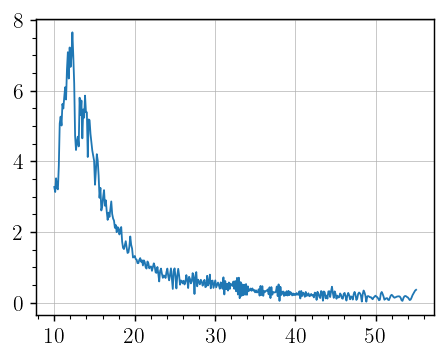

In [33]:
step = data[3]
plt.plot(step.freqs, np.abs(step.chi_abs + 1j * step.chi_im))

In [34]:
def theory(x: np.ndarray, I: float, w0: float, alpha: float) -> np.ndarray:
    return 1 / np.sqrt(
        (I * (w0**2 - x**2))**2 + (alpha * x)**2
    )

[I, omega, alpha] =  [3.43595346e-03 1.09086331e+01 1.90732383e-02]


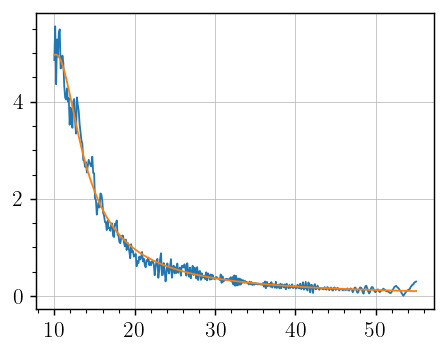

[I, omega, alpha] =  [3.50578768e-03 1.10235826e+01 1.06920064e-02]


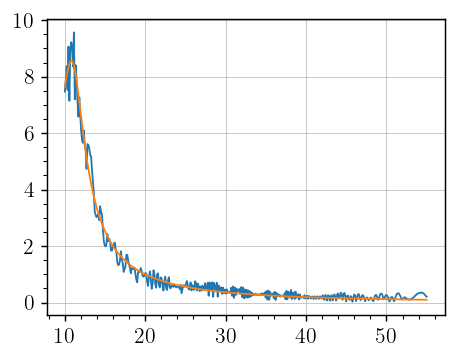

[I, omega, alpha] =  [3.12290724e-03 1.28582750e+01 1.48000948e-02]


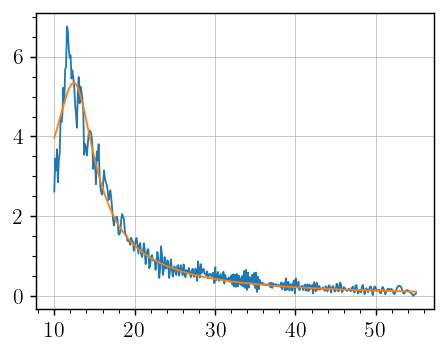

[I, omega, alpha] =  [2.94465437e-03 1.34712626e+01 1.69291002e-02]


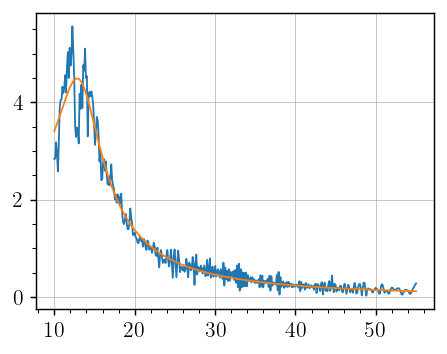

[I, omega, alpha] =  [3.05398160e-03 1.36840718e+01 1.68856864e-02]


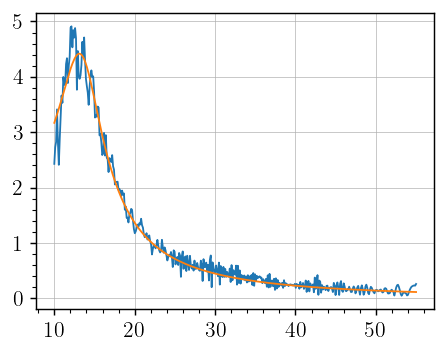

[I, omega, alpha] =  [2.81236498e-03 1.66519961e+01 4.10026604e-02]


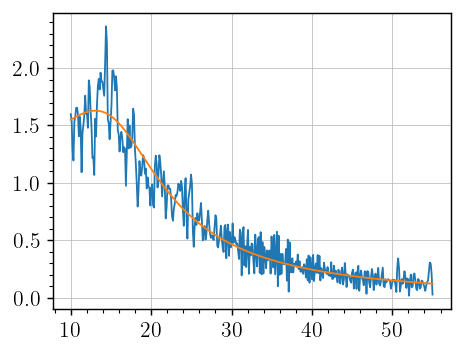

[I, omega, alpha] =  [2.89524606e-03 2.11420004e+01 3.57075142e-02]


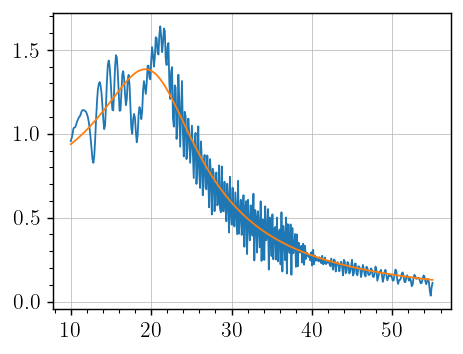

[I, omega, alpha] =  [3.61717833e-03 1.14661235e+01 1.07839025e-02]


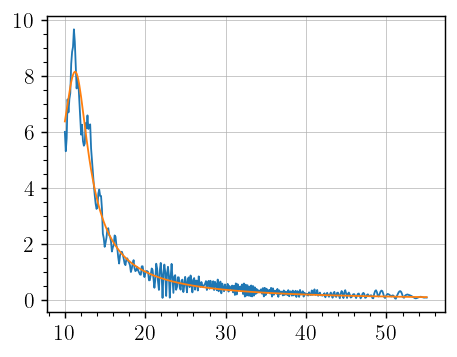

[I, omega, alpha] =  [3.48583515e-03 1.16618925e+01 1.09569518e-02]


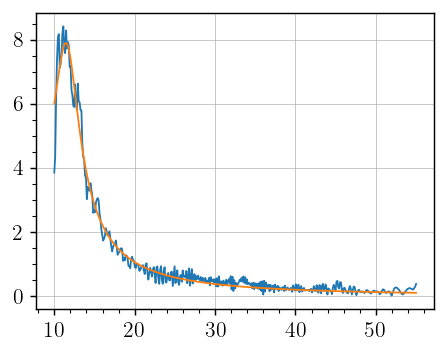

[I, omega, alpha] =  [3.14089803e-03 1.16928468e+01 1.58983190e-02]


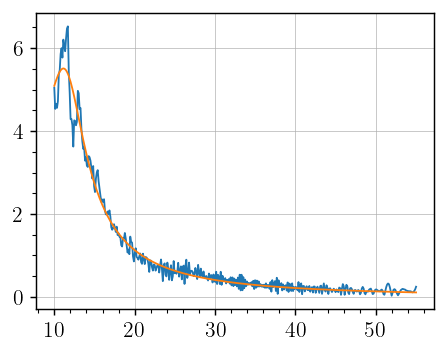

[I, omega, alpha] =  [2.99725717e-03 1.18512963e+01 1.56904247e-02]


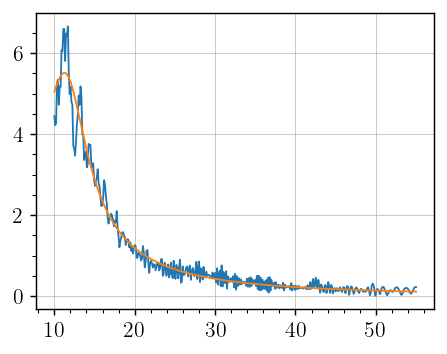

[I, omega, alpha] =  [2.99217540e-03 1.22991541e+01 1.09385859e-02]


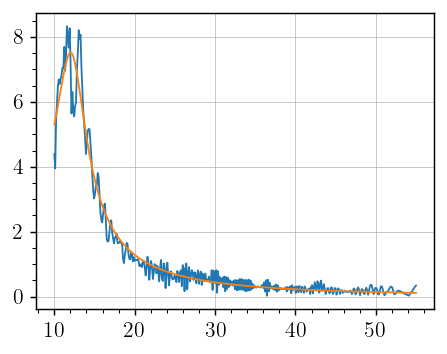

[I, omega, alpha] =  [3.19873066e-03 1.23224121e+01 1.50596201e-02]


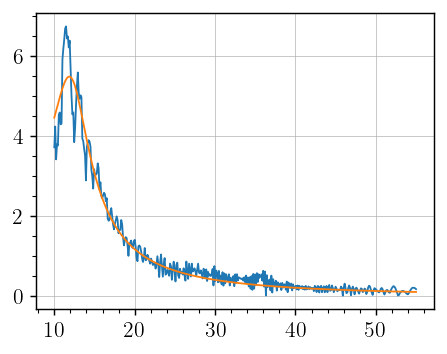

[I, omega, alpha] =  [2.96931798e-03 1.27267586e+01 9.91837014e-03]


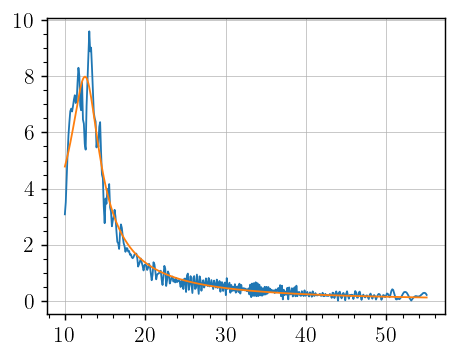

[I, omega, alpha] =  [3.08200586e-03 1.35567871e+01 2.03804122e-02]


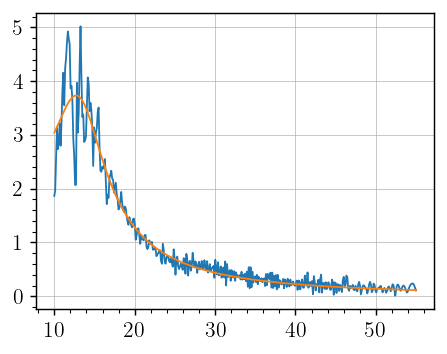

In [39]:
for step in data:
    popt, pcov = sc.optimize.curve_fit(
        theory, step.freqs, step.chi_abs,
        bounds=(0, np.inf)
    )
    print("[I, omega, alpha] = ", popt)
    plt.plot(step.freqs, step.chi_abs)
    plt.plot(step.freqs, theory(step.freqs, *popt))
    plt.show()